<a href="https://colab.research.google.com/github/ESiler/umich_mads/blob/main/data_analysis_and_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Set-up: Load dependencies, mount drive, load data

In [ ]:
#load libraries
import pandas as pd
import json
import datetime as dt
import numpy as np
from datetime import datetime, timedelta
import os as os
import pandas.api.types as ptypes
import re
import csv
import string
import openpyxl
import sys
import ast
from google.colab import drive

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from collections import Counter

In [ ]:
#from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
## Config
data_folder = '/content/drive/MyDrive/SIADS_593_Milestone_I/cleaned_merged_data/'
#Load data
df = pd.read_csv((data_folder + 'merged_data.csv'))
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15885 entries, 0 to 15884
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   case number                   15885 non-null  object 
 1   case name                     15885 non-null  object 
 2   date filed                    15885 non-null  object 
 3   date closed                   15885 non-null  object 
 4   reason closed                 15885 non-null  object 
 5   employees on charge/petition  15859 non-null  float64
 6   voters                        11379 non-null  float64
 7   related cases                 15885 non-null  object 
 8   number of related cases       544 non-null    float64
 9   rel_case_nums                 15885 non-null  object 
 10  rel_dates_filed               15885 non-null  object 
 11  rel_dates_closed              15885 non-null  object 
 12  rel_reasons_closed            15885 non-null  object 
 13  r

,case number,case name,date filed,date closed,reason closed,employees on charge/petition,voters,related cases,number of related cases,rel_case_nums,rel_dates_filed,rel_dates_closed,rel_reasons_closed,rel_allegations
0,01rc332644,brown university,2023-12-28,2024-01-12,withdrawal non-adjusted,380.0,NaN,[],NaN,[],[],[],[],[]
1,13rc332604,"lakeshore recycling systems, llc",2023-12-28,2024-01-30,certific. of representative,5.0,5.0,[],NaN,[],[],[],[],[]
2,28rc332613,"albuquerque mail service, inc.",2023-12-27,2024-01-30,certific. of representative,49.0,75.0,[],NaN,[],[],[],[],[]


In [ ]:
#Encode results for union wins and losses
union_wins = ['certific. of representative', 'compliance w/bo']
union_does_not_win = ['withdrawal non-adjusted', 'certification of results',
                      'dismissal non-adjusted', 'withdrawal adjusted', 'amended certification', 'dismissal adjusted']

# Add union_win column to df
def encode_union_win(x):
  if x in union_wins:
    val = 1
  elif x in union_does_not_win:
    val = 0
  else:
    val = None
  return val

df['union_win'] = df['reason closed'].apply(encode_union_win)

#Drop rows without union win designation
#


# Group month vs win rate
df['date filed'] = pd.to_datetime(df['date filed'])
df['date closed'] = pd.to_datetime(df['date closed'])

df['month_filed'] = df['date filed'].dt.to_period('M')

df['has_related_cases'] = df['number of related cases'].apply(lambda x: 1 if x>0 else 0)

df = df.dropna(subset=['union_win']) #get rid of ambigous or unknown outcomes

sum(df['union_win'].value_counts()), len(df)

(15883, 15883)

Research Questions:

In the current context of a public surge in pro-union sentiment, what are election win rates for workers seeking to form unions?

Has the change in presidential administration to being a pro-union administration had a noticeable effect on the rate of ULP submission winnings?

Are union win rates correlated to ULP charge activity?

What are the indicators of employer hostility (or even illegality) towards organizing? (shown through number of allegations and number of charges filed) -- specific allegation types & amounts

How effective is the recourse that workers have if the employer does break the law, and what effect does that have on the election? [C case outcome vs whether election was won.]


### 1. In the current context of a public surge in pro-union sentiment, what are election win rates for workers seeking to form unions?

In [ ]:
#Statistical model of monthly win rate trends
monthly_win_df = df.groupby(['month_filed'])['union_win'].mean().reset_index()
petitions_filed = df['month_filed'].value_counts()
monthly_win_df = monthly_win_df.merge(petitions_filed, left_on='month_filed', right_index=True, how='inner')
monthly_win_df['month_filed'] = monthly_win_df['month_filed'].astype(str)

monthly_win_df = monthly_win_df.rename(columns={'month_filed_y': 'petitions_filed'})

# Drop the redundant 'month_filed_x' column
monthly_win_df = monthly_win_df.drop(columns='month_filed_x')

monthly_win_df['month_filed_numeric'] = range(len(monthly_win_df))

X = monthly_win_df['month_filed_numeric'].values.reshape(-1, 1)
y = monthly_win_df['union_win'].values.reshape(-1, 1)

# Fit linear regression model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Predict union_win values using linear regression model
y_pred = model.predict(X)

print(model.summary(), '\n', '\n')


print("Win rate change per year (percentage points)", model.params[1]*12*100)
print("Win rate change from 2015 to 2023:", y_pred[0], y_pred[-1])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     22.21
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           7.46e-06
Time:                        21:13:53   Log-Likelihood:                 171.47
No. Observations:                 108   AIC:                            -338.9
Df Residuals:                     106   BIC:                            -333.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4834      0.010     50.668      0.0

In [ ]:
petitions_filed.head()

2022-03    235
2015-04    232
2022-04    219
2017-03    208
2016-04    203
Freq: M, Name: month_filed, dtype: int64

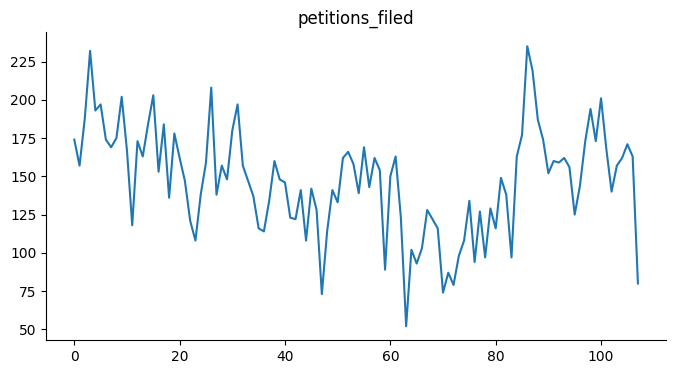

In [ ]:
from matplotlib import pyplot as plt
monthly_win_df['petitions_filed'].plot(kind='line', figsize=(8, 4), title='petitions_filed')
plt.gca().spines[['top', 'right']].set_visible(False)

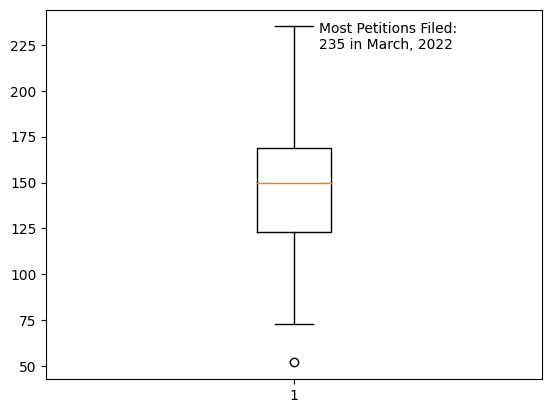

In [ ]:

boxplot = plt.boxplot(monthly_win_df['petitions_filed'])
ax = plt.gca()
ax.annotate("Most Petitions Filed:\n235 in March, 2022", (1.05, 223))
plt.show()

Plot union win rate over time + trend

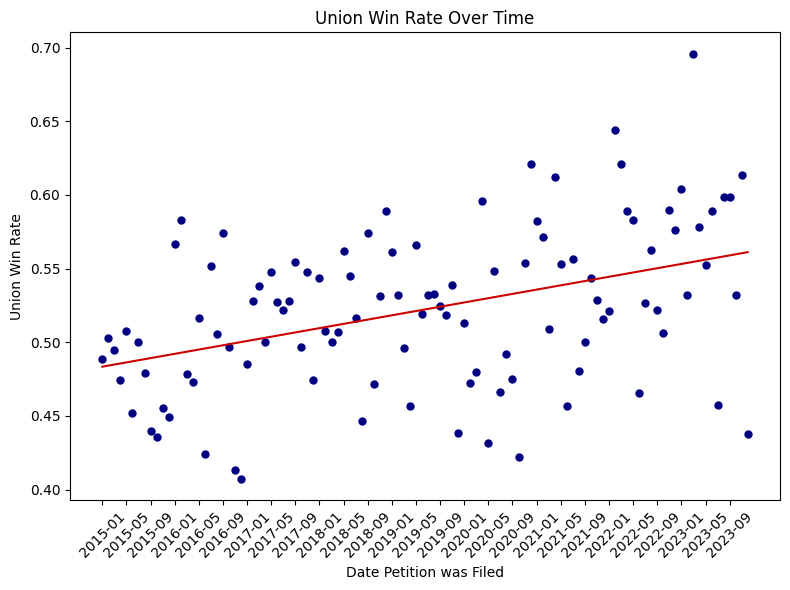

In [ ]:
# Plot the data using Matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(monthly_win_df['month_filed'], monthly_win_df['union_win'], color='navy', s=25)
plt.plot(X[:, 1], y_pred, color="#cc0000", label='Regression Line')
plt.title('Union Win Rate Over Time')
plt.xlabel('Date Petition was Filed')
plt.ylabel('Union Win Rate')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xticks(monthly_win_df.index[::4], monthly_win_df['month_filed'].iloc[::4], rotation=45)


plt.tight_layout()
plt.show()

### 2. Are union win rates correlated to ULP charge activity?

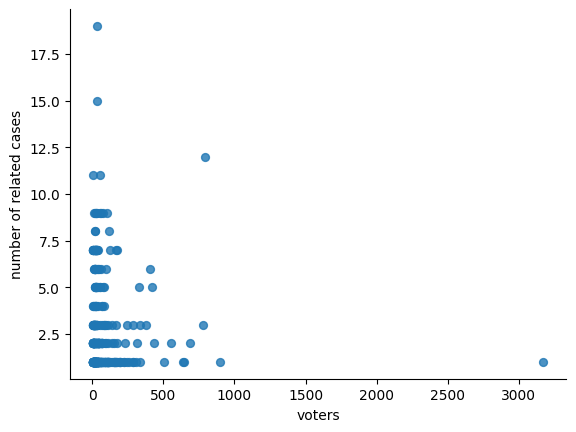

In [ ]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='voters', y='number of related cases', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

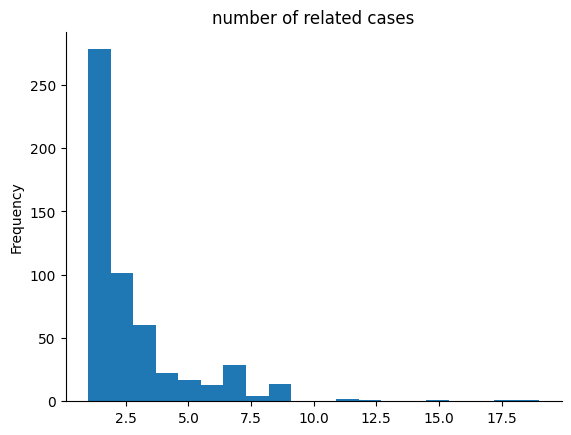

In [ ]:
from matplotlib import pyplot as plt
df['number of related cases'].plot(kind='hist', bins=20, title='number of related cases')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-10-6de95c0233d5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='number of related cases', y='reason closed', inner='box', palette='Dark2')


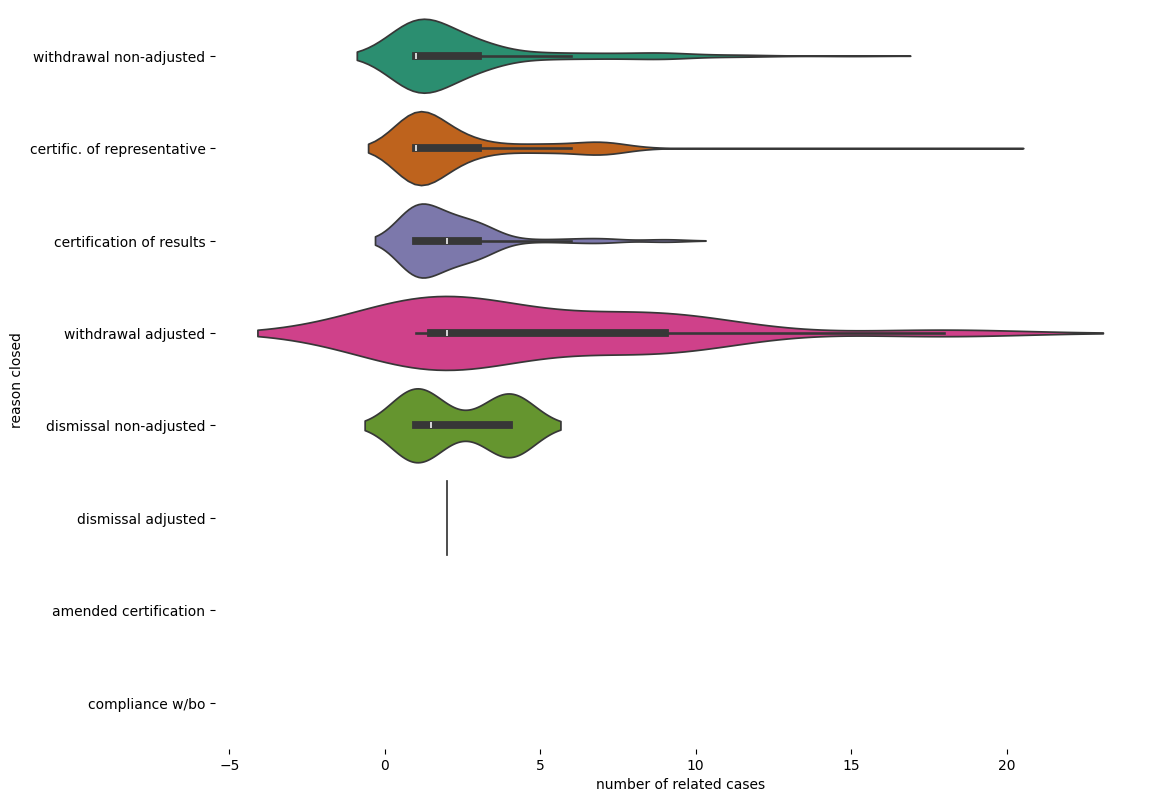

In [ ]:
# reason closed vs number of related cases

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['reason closed'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='number of related cases', y='reason closed', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#Do cases with ULPs have a lower win rate?
contingency_table = pd.crosstab(df['has_related_cases'], df['union_win'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

# Plot win rate vs ULP cases filed
union_win_v_ulp = df.groupby('has_related_cases')['union_win'].mean()
print(union_win_v_ulp)

Chi-square statistic: 16.842936407135824
P-value: 4.060416999016592e-05
Degrees of freedom: 1
Expected frequencies: [[7317.48429138 8021.51570862]
 [ 259.51570862  284.48429138]]
has_related_cases
0    0.526045
1    0.435662
Name: union_win, dtype: float64


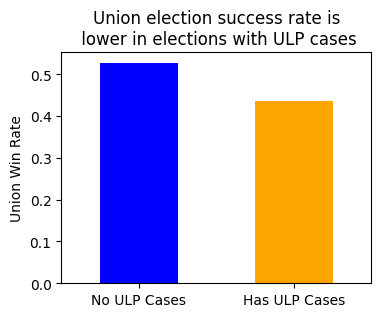

In [ ]:
# Plot the average union_win for each group
plt.figure(figsize=(4,3))
union_win_v_ulp.plot(kind='bar', color=['blue', 'orange'])
plt.title('Union election success rate is\n lower in elections with ULP cases')
plt.xlabel(None)
plt.ylabel('Union Win Rate')
plt.xticks(ticks=[0, 1], labels=['No ULP Cases', 'Has ULP Cases'], rotation=0)
plt.show()


In [ ]:
#2. ulp cases before or after?
df_with_ulps = df[df['has_related_cases']==1]

#3. ULP cases vs election win rate, by ULP type
#df_with_ulps.info()
has_timestamp = df['rel_dates_filed'].str.contains('Timestamp').sum()
print("Only", has_timestamp, "rows with related cases have a timestamp associated.")

Only 32 rows with related cases have a timestamp associated.


In [ ]:
##
df['month_filed'] = df['month_filed'].astype(str)
df = pd.merge(df, monthly_win_df, on='month_filed', how='left')
df.rename(columns={'union_win_x': 'union_win'}, inplace=True)
df['union_win'] = df['union_win'].astype('int64')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15883 entries, 0 to 15882
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case number                   15883 non-null  object        
 1   case name                     15883 non-null  object        
 2   date filed                    15883 non-null  datetime64[ns]
 3   date closed                   15883 non-null  datetime64[ns]
 4   reason closed                 15883 non-null  object        
 5   employees on charge/petition  15857 non-null  float64       
 6   voters                        11378 non-null  float64       
 7   related cases                 15883 non-null  object        
 8   number of related cases       544 non-null    float64       
 9   rel_case_nums                 15883 non-null  object        
 10  rel_dates_filed               15883 non-null  object        
 11  rel_dates_closed            

In [ ]:
##Is the correlation between ULP cases and union success just because fewer have been filed as success has risen?
X = df[['month_filed_numeric', 'has_related_cases']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df['union_win']

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Predict union_win values using linear regression model
y_pred = model.predict(X)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              union_win   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     29.70
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           1.34e-13
Time:                        14:54:57   Log-Likelihood:                -11481.
No. Observations:               15883   AIC:                         2.297e+04
Df Residuals:                   15880   BIC:                         2.299e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4850    

In [ ]:
# Extract the year from the datetime column
df['year'] = df['date filed'].dt.year

# Calculate the mean of 'union_win' for has_related_cases == 0
mean_union_win_no_cases = df[df['has_related_cases'] == 0].groupby('year')['union_win'].mean()

# Calculate the mean of 'union_win' for has_related_cases == 1
mean_union_win_has_cases = df[df['has_related_cases'] == 1].groupby('year')['union_win'].mean()

# Create a DataFrame to display the results
mean_union_win_by_year = pd.DataFrame({
    'Mean_Union_Win_No_Cases': mean_union_win_no_cases,
    'Mean_Union_Win_Has_Cases': mean_union_win_has_cases
})

# Print the summary DataFrame
mean_union_win_by_year

,Mean_Union_Win_No_Cases,Mean_Union_Win_Has_Cases
year,,
2015,0.481155,0.320388
2016,0.508215,0.360465
2017,0.525910,0.441176
2018,0.521681,0.450000
2019,0.522020,0.407407
2020,0.498440,0.419355
2021,0.537643,0.392157
2022,0.555893,0.695652
2023,0.578723,0.369565


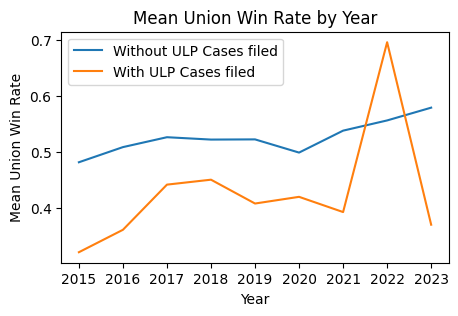

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(mean_union_win_by_year.index, mean_union_win_by_year['Mean_Union_Win_No_Cases'], label='Without ULP Cases filed')
plt.plot(mean_union_win_by_year.index, mean_union_win_by_year['Mean_Union_Win_Has_Cases'], label='With ULP Cases filed')
plt.title('Mean Union Win Rate by Year')
plt.xlabel('Year')
plt.ylabel('Mean Union Win Rate')
plt.legend()

plt.show()

### 3.  What are the indicators of employer hostility (or even illegality) towards organizing? (shown through number of allegations and number of charges filed) -- specific allegation types & amounts

In [ ]:
# X = time, Y = frequency of different types of labor allegation (1-5).
# a) rel frequency b) absolute frequency
df_with_ulps['has_rel_case_info'] = df_with_ulps['rel_case_nums'].apply(lambda x: 1 if len(x)>0 else 0)

<ipython-input-18-610e9e4f7b78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_ulps['has_rel_case_info'] = df_with_ulps['rel_case_nums'].apply(lambda x: 1 if len(x)>0 else 0)


In [ ]:
rel_cols = ['rel_case_nums','rel_reasons_closed','rel_allegations']
for col in rel_cols:
  df_with_ulps[col] = df_with_ulps[col].apply(lambda x: eval(x))
df_with_ulps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 7 to 15865
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case number                   544 non-null    object        
 1   case name                     544 non-null    object        
 2   date filed                    544 non-null    datetime64[ns]
 3   date closed                   544 non-null    datetime64[ns]
 4   reason closed                 544 non-null    object        
 5   employees on charge/petition  544 non-null    float64       
 6   voters                        371 non-null    float64       
 7   related cases                 544 non-null    object        
 8   number of related cases       544 non-null    float64       
 9   rel_case_nums                 544 non-null    object        
 10  rel_dates_filed               544 non-null    object        
 11  rel_dates_closed              

<ipython-input-19-c4524374040c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_ulps[col] = df_with_ulps[col].apply(lambda x: eval(x))


## Load and analyze C case data

In [ ]:
dtype_dict = {'case number':str, 'case name': str, 'date filed': str,
              'date closed':str, 'reason closed':str, 'employees on charge/petition': 'float64',
              'allegations':str}

In [ ]:
C_case_df = pd.read_csv(data_folder + 'df2_C_cases.csv', dtype=dtype_dict)
#to_datetime
C_case_df['date filed'] = pd.to_datetime(C_case_df['date filed'])
C_case_df['date closed'] = pd.to_datetime(C_case_df['date closed'])
#Add case outcomes


In [ ]:
C_case_df.info()
C_case_df.sample(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145536 entries, 0 to 145535
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   case number                   145536 non-null  object        
 1   case name                     145536 non-null  object        
 2   date filed                    15550 non-null   datetime64[ns]
 3   date closed                   15550 non-null   datetime64[ns]
 4   reason closed                 145536 non-null  object        
 5   employees on charge/petition  15524 non-null   float64       
 6   allegations                   145363 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 7.8+ MB


,case number,case name,date filed,date closed,reason closed,employees on charge/petition,allegations
44684,13ca206746,"solvay usa, inc.",NaT,NaT,withdrawal adjusted,NaN,8(a)(5) repudiation/modification of contract [...


In [ ]:
#C ceses with timestamps
C_case_timestamped = C_case_df.dropna(subset=['date closed'])
C_case_timestamped = C_case_timestamped.dropna(subset=['allegations'])
C_case_timestamped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15490 entries, 0 to 19600
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case number                   15490 non-null  object        
 1   case name                     15490 non-null  object        
 2   date filed                    15490 non-null  datetime64[ns]
 3   date closed                   15490 non-null  datetime64[ns]
 4   reason closed                 15490 non-null  object        
 5   employees on charge/petition  15464 non-null  float64       
 6   allegations                   15490 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 968.1+ KB


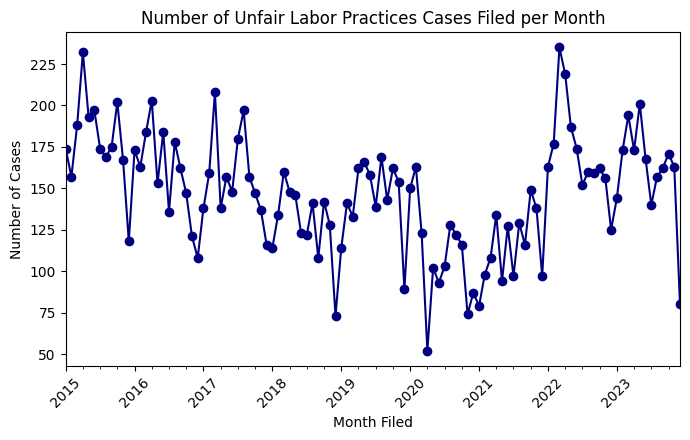

In [ ]:
#Is there a trend in the number of cases filed per month?
cases_per_month = df.groupby(df['date filed'].dt.to_period('M')).size()

# Plot the data
plt.figure(figsize=(7, 4.5))
cases_per_month.plot(kind='line', color='navy', marker='o', linestyle='-')
plt.title('Number of Unfair Labor Practices Cases Filed per Month')
plt.xlabel('Month Filed')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
C_case_timestamped['allegations'] = C_case_timestamped['allegations'].apply(lambda x: x[:-1].split('\n'))


In [ ]:
#systematically displaying all possible C case types that are possible.
for i in range(5):
  print(C_case_timestamped.iloc[i]['allegations'], type(C_case_timestamped.iloc[i]['allegations']))

["8(b)(1)(a) duty of fair representation, incl'g superseniority, denial of access"] <class 'list'>
['8(a)(1) concerted activities (retaliation, discharge, discipline)', '8(a)(1) coercive actions (surveillance, etc)', '8(a)(1) coercive statements (threats, promises of benefits, etc.)'] <class 'list'>
["8(b)(1)(a) duty of fair representation, incl'g superseniority, denial of access"] <class 'list'>
["8(b)(1)(a) duty of fair representation, incl'g superseniority, denial of access"] <class 'list'>
['8(a)(1) coercive actions (surveillance, etc)', '8(a)(5) refusal to furnish information', '8(a)(3) lockout'] <class 'list'>


In [ ]:
#What are the different allegation codes?
alleg_codes = []
for index, row in C_case_timestamped.iterrows():
  allegs = row['allegations']
  for a in allegs:
    code = a.split()[0]
    alleg_codes+=[code]

alleg_codes = Counter(alleg_codes)


In [ ]:
#Most common allegations and their frequenties
allegs_common = dict(alleg_codes.most_common(9))

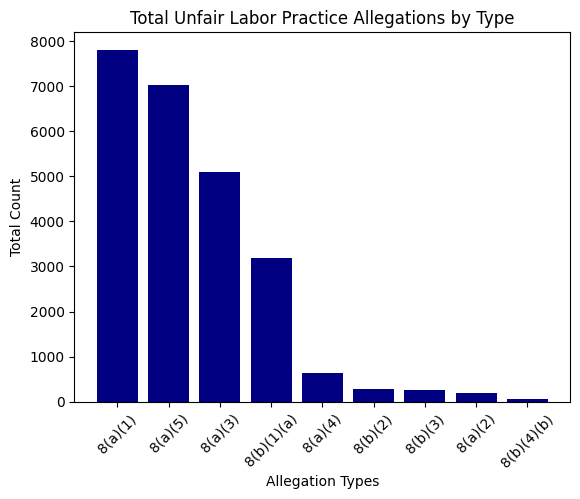

In [ ]:
def make_alleg_bar_graph(alleg_codes=alleg_codes):
  #labels, counts = zip(*alleg_codes.items())
  plt.bar(allegs_common.keys(), allegs_common.values(), color='navy')
  plt.xlabel('Allegation Types')
  plt.ylabel('Total Count')
  plt.title('Total Unfair Labor Practice Allegations by Type')
  plt.xticks(rotation=45)
  # Show the plot
  plt.show()
make_alleg_bar_graph()

In [ ]:
C_case_timestamped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15490 entries, 0 to 19600
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case number                   15490 non-null  object        
 1   case name                     15490 non-null  object        
 2   date filed                    15490 non-null  datetime64[ns]
 3   date closed                   15490 non-null  datetime64[ns]
 4   reason closed                 15490 non-null  object        
 5   employees on charge/petition  15464 non-null  float64       
 6   allegations                   15490 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 968.1+ KB


In [ ]:
C_case_timestamped_x = C_case_timestamped.explode('allegations')
C_case_timestamped_x['allegations'].value_counts()
#There are exactly 68 unique allegations. I originally thought these were more free-form.

8(a)(5) repudiation/modification of contract [sec 8(d)/unilateral changes]         2753
8(b)(1)(a) duty of fair representation, incl'g superseniority, denial of access    2594
8(a)(1) concerted activities (retaliation, discharge, discipline)                  2560
8(a)(1) coercive statements (threats, promises of benefits, etc.)                  1952
8(a)(5) refusal to furnish information                                             1951
                                                                                   ... 
8(e) all allegations against an employer                                              2
8(b)(4)(a) lawsuits/grievances                                                        2
8(b)(4)(b) lawsuits/grievances                                                        1
8(b)(4)(c) lawsuits/grievances                                                        1
8(b)(7)(a) all allegations                                                            1
Name: allegations, Length: 68, d

In [ ]:
len(C_case_timestamped_x)

24642

In [ ]:
df.head()

,case number,case name,date filed,date closed,reason closed,employees on charge/petition,voters,related cases,number of related cases,rel_case_nums,...,rel_dates_closed,rel_reasons_closed,rel_allegations,union_win,month_filed,has_related_cases,union_win_y,petitions_filed,month_filed_numeric,year
0,01rc332644,brown university,2023-12-28,2024-01-12,withdrawal non-adjusted,380.0,NaN,[],NaN,[],...,[],[],[],0,2023-12,0,0.4375,80,107,2023
1,13rc332604,"lakeshore recycling systems, llc",2023-12-28,2024-01-30,certific. of representative,5.0,5.0,[],NaN,[],...,[],[],[],1,2023-12,0,0.4375,80,107,2023
2,28rc332613,"albuquerque mail service, inc.",2023-12-27,2024-01-30,certific. of representative,49.0,75.0,[],NaN,[],...,[],[],[],1,2023-12,0,0.4375,80,107,2023
3,07rc332691,dmc- children's hospital of michigan,2023-12-27,2024-01-19,withdrawal non-adjusted,58.0,NaN,[],NaN,[],...,[],[],[],0,2023-12,0,0.4375,80,107,2023
4,10rc332574,"duke university health system, inc., d/b/a duk...",2023-12-27,2024-02-02,certific. of representative,24.0,25.0,[],NaN,[],...,[],[],[],1,2023-12,0,0.4375,80,107,2023


In [ ]:
df.columns.tolist()

['case number',
 'case name',
 'date filed',
 'date closed',
 'reason closed',
 'employees on charge/petition',
 'voters',
 'related cases',
 'number of related cases',
 'rel_case_nums',
 'rel_dates_filed',
 'rel_dates_closed',
 'rel_reasons_closed',
 'rel_allegations',
 'union_win',
 'month_filed',
 'has_related_cases',
 'union_win_y',
 'petitions_filed',
 'month_filed_numeric',
 'year']

In [ ]:
C_case_timestamped_x.head()

,case number,case name,date filed,date closed,reason closed,employees on charge/petition,allegations
0,08cb166906,teamsters local 20 a/w international brotherho...,2023-12-28,2024-01-12,withdrawal non-adjusted,380.0,"8(b)(1)(a) duty of fair representation, incl'g..."
1,07ca167075,"kruse & muer restaurants, kruse & muer on main",2023-12-28,2024-01-30,withdrawal adjusted,5.0,"8(a)(1) concerted activities (retaliation, dis..."
1,07ca167075,"kruse & muer restaurants, kruse & muer on main",2023-12-28,2024-01-30,withdrawal adjusted,5.0,"8(a)(1) coercive actions (surveillance, etc)"
1,07ca167075,"kruse & muer restaurants, kruse & muer on main",2023-12-28,2024-01-30,withdrawal adjusted,5.0,"8(a)(1) coercive statements (threats, promises..."
2,15cb166935,"iue-cwa, the industrial division of communicat...",2023-12-27,2024-01-30,withdrawal non-adjusted,49.0,"8(b)(1)(a) duty of fair representation, incl'g..."


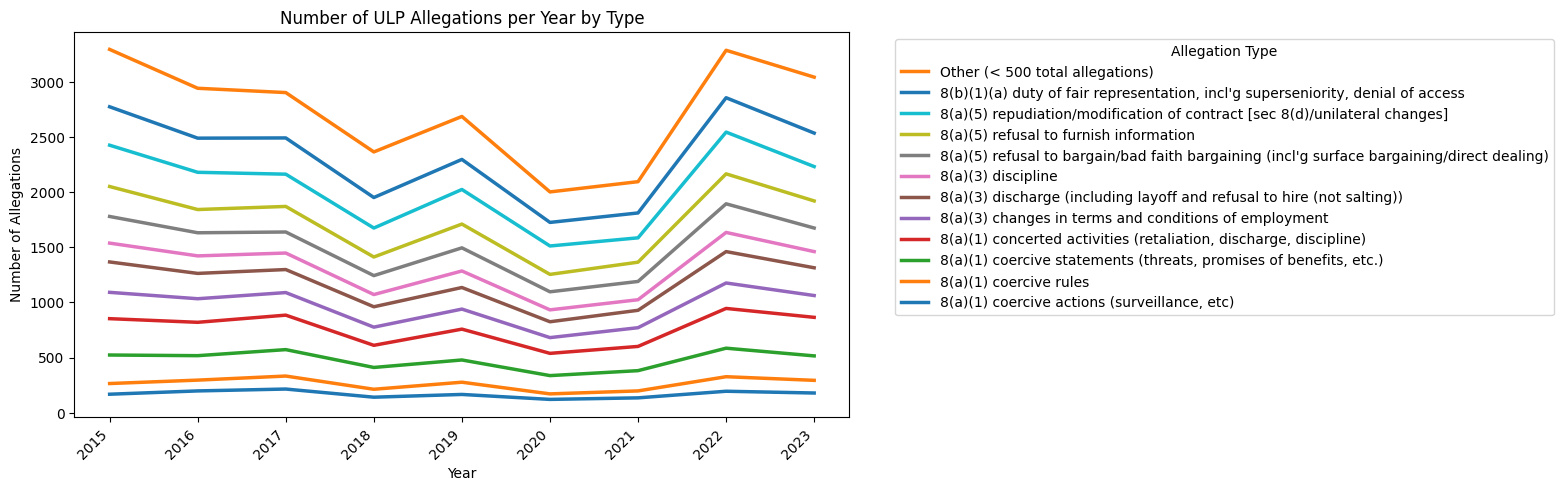

In [ ]:
#Trends in specific allegations?

def make_ulp_types_graph(df=C_case_timestamped_x, cutoff=500, title='Number of ULP Allegations per Year by Type'):
    df = df.copy()
    df['year'] = df['date filed'].dt.year

    # Group by year and ULP allegation type and count occurrences
    ulp_counts = df.groupby(['year', 'allegations']).size().unstack(fill_value=0)

    # Sum the counts of allegation types with less than (cutoff) counts and add a new 'Other' category
    ulp_counts_other = ulp_counts.loc[:, ulp_counts.sum() < cutoff].sum(axis=1)
    ulp_counts_other.name = ' '.join(['Other (<', str(cutoff), 'total allegations)'])
    ulp_counts = ulp_counts.loc[:, ulp_counts.sum() >= cutoff]
    ulp_counts = pd.concat([ulp_counts, ulp_counts_other], axis=1)

    # Plot the data
    plt.style.use('default')
    ax = ulp_counts.plot(kind='line', stacked=True, figsize=(10, 5), linewidth=2.5)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Number of Allegations')
    plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability

    # Separate legend plot
    plt.legend(title='Allegation Type', bbox_to_anchor=(1.05, 1), loc='upper left', reverse=True)
    #legend.figure.tight_layout()
    plt.show()

# Call the function
make_ulp_types_graph()

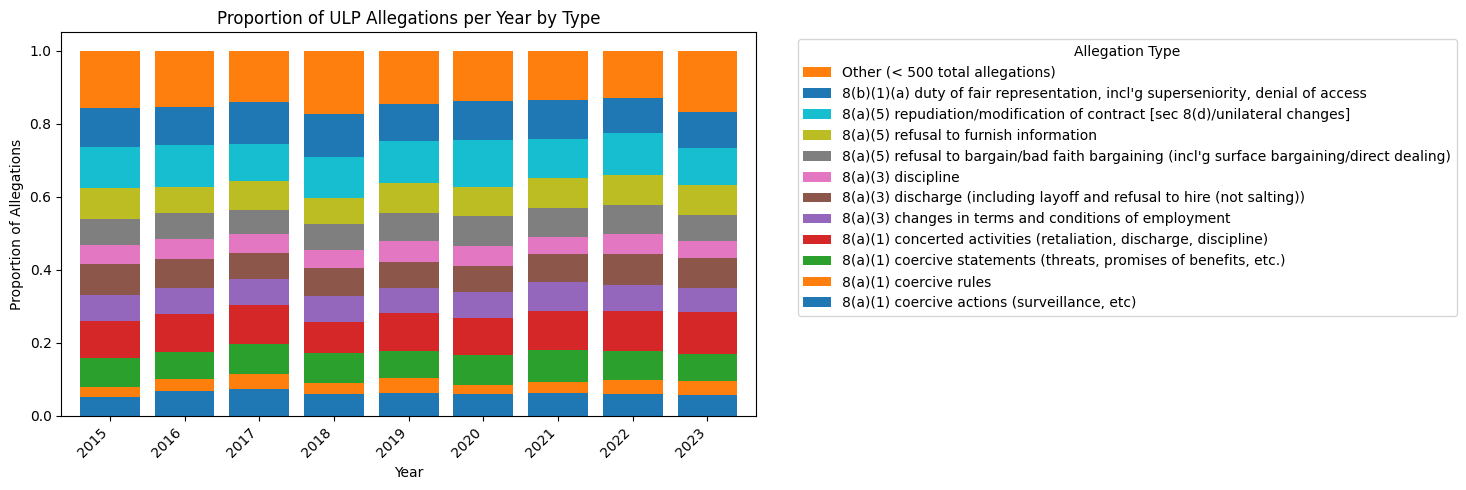

In [ ]:
def make_ulp_proportions_graph(df=C_case_timestamped_x, cutoff=500, title = 'Proportion of ULP Allegations per Year by Type'):

    # Extract year from 'date filed'
    df = df.copy()
    df['year'] = df['date filed'].dt.year

    # Group by year and ULP allegation type and count occurrences
    ulp_counts = df.groupby(['year', 'allegations']).size().unstack(fill_value=0)

    # Sum the counts of allegation types with less than (cutoff) counts and add a new 'Other' category
    ulp_counts_other = ulp_counts.loc[:, ulp_counts.sum() < cutoff].sum(axis=1)
    ulp_counts_other.name = ' '.join(['Other (<', str(cutoff), 'total allegations)'])
    ulp_counts = ulp_counts.loc[:, ulp_counts.sum() >= cutoff]
    ulp_counts = pd.concat([ulp_counts, ulp_counts_other], axis=1)

    # Calculate proportions
    ulp_proportions = ulp_counts.div(ulp_counts.sum(axis=1), axis=0)

    # Plot the data
    plt.style.use('default')
    #plt.style.use('seaborn-v0_8-white')
    ax = ulp_proportions.plot(kind='bar', stacked=True, figsize=(15, 5), width=0.8)  # Adjust width here

    # Customizing the plot
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Proportion of Allegations')
    plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
    plt.legend(title='Allegation Type', bbox_to_anchor=(1.05, 1), loc='upper left', reverse=True)

    plt.tight_layout()
    plt.show()

# Call the function
make_ulp_proportions_graph()

In [ ]:
## Look at trends in ULP allegations that are specific to union elections

## Get list of relavent C cases:
rel_cases = []
for index, row in df_with_ulps.iterrows():
  rel_cases += row['rel_case_nums']
#Add is_relevant column
C_case_timestamped_x['is_relevant'] = C_case_timestamped_x['case number'].isin(rel_cases).astype(int)
## get subset of C dataset containing relevant cases
C_case_rel = C_case_timestamped_x[C_case_timestamped_x['is_relevant'] == 1]
C_case_rel.sample(2)
C_case_rel.info()
C_case_rel['case number'].nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 260 to 18496
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case number                   135 non-null    object        
 1   case name                     135 non-null    object        
 2   date filed                    135 non-null    datetime64[ns]
 3   date closed                   135 non-null    datetime64[ns]
 4   reason closed                 135 non-null    object        
 5   employees on charge/petition  135 non-null    float64       
 6   allegations                   135 non-null    object        
 7   is_relevant                   135 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 9.5+ KB


64

In [ ]:
len(rel_cases)


359

In [ ]:
## Get list of relavent C cases :
C_case_x = C_case_df.explode('allegations')
#C_case_timestamped_x['allegations'].value_counts()
rel_cases = []
for index, row in df_with_ulps.iterrows():
  rel_cases += row['rel_case_nums']
#Add is_relevant column
C_case_x['is_relevant'] = C_case_x['case number'].isin(rel_cases).astype(int)
## get subset of C dataset containing relevant cases
C_case_rel = C_case_x[C_case_x['is_relevant'] == 1]
C_case_rel.sample(2)
C_case_rel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 258 to 143295
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case number                   353 non-null    object        
 1   case name                     353 non-null    object        
 2   date filed                    64 non-null     datetime64[ns]
 3   date closed                   64 non-null     datetime64[ns]
 4   reason closed                 353 non-null    object        
 5   employees on charge/petition  64 non-null     float64       
 6   allegations                   351 non-null    object        
 7   is_relevant                   353 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 24.8+ KB


In [ ]:
C_case_rel['case name'].nunique()

162

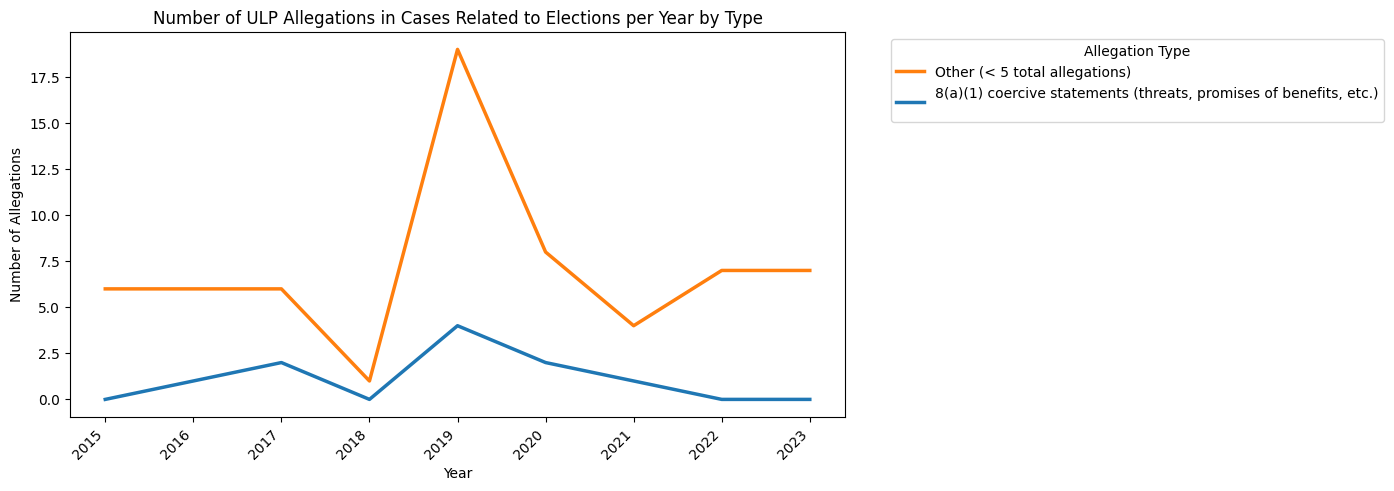

In [ ]:
#Trends in specific allegations relevant to election cases
make_ulp_types_graph(df=C_case_rel, cutoff=5, title = "Number of ULP Allegations in Cases Related to Elections per Year by Type")

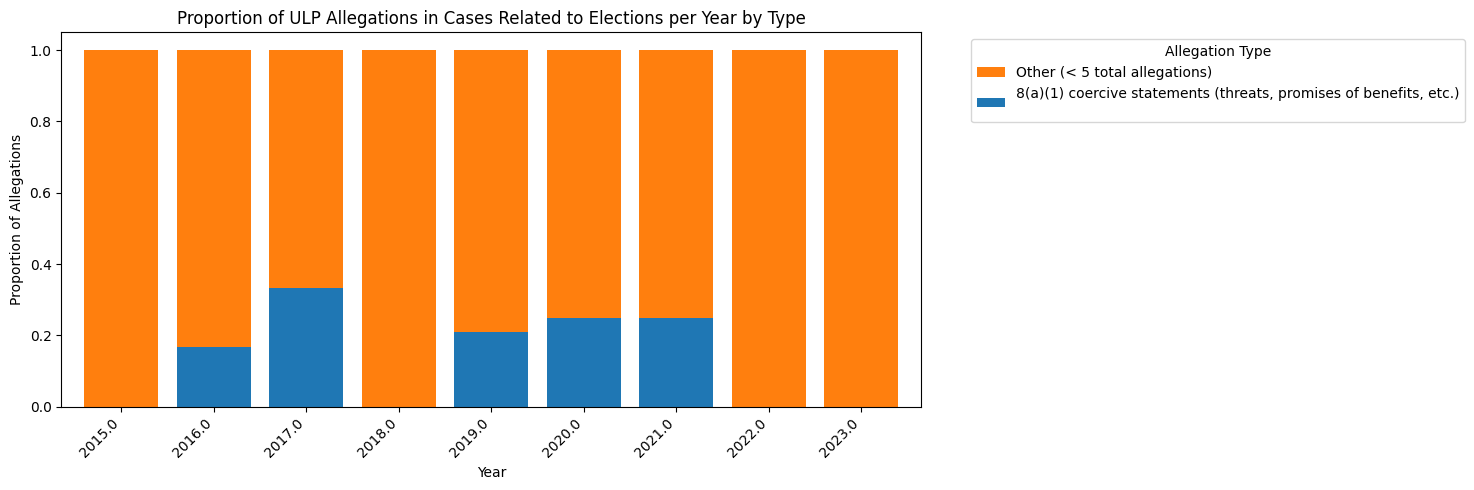

In [ ]:
plot = make_ulp_proportions_graph(df=C_case_rel, cutoff=5, title = "Proportion of ULP Allegations in Cases Related to Elections per Year by Type")

In [ ]:
C_case_timestamped_x.sample(1)

,case number,case name,date filed,date closed,reason closed,employees on charge/petition,allegations,is_relevant
18281,09ca145189,at&t mobility,2015-06-16,2015-07-27,withdrawal non-adjusted,50.0,8(a)(1) weingarten,0


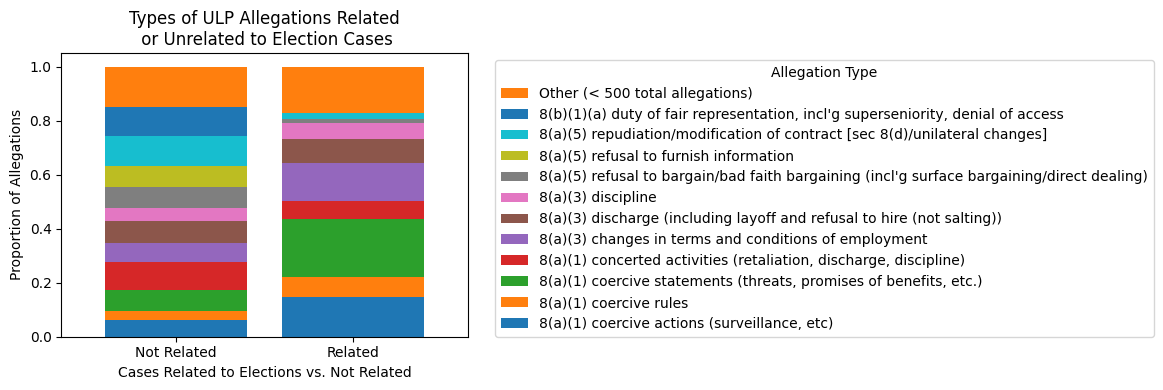

In [ ]:
## Do elections-related cases have a different composition of ULPs than non-related ones?
def rel_ulp_proportions_graph(df=C_case_timestamped_x, cutoff=500, title = 'Types of ULP Allegations Related\n or Unrelated to Election Cases'):

    # Extract year from 'date filed'
    df = df.copy()

    # Group by year and ULP allegation type and count occurrences
    ulp_counts = df.groupby(['is_relevant', 'allegations']).size().unstack(fill_value=0)

    # Sum the counts of allegation types with less than (cutoff) counts and add a new 'Other' category
    ulp_counts_other = ulp_counts.loc[:, ulp_counts.sum() < cutoff].sum(axis=1)
    ulp_counts_other.name = ' '.join(['Other (<', str(cutoff), 'total allegations)'])
    ulp_counts = ulp_counts.loc[:, ulp_counts.sum() >= cutoff]
    ulp_counts = pd.concat([ulp_counts, ulp_counts_other], axis=1)

    # Calculate proportions
    ulp_proportions = ulp_counts.div(ulp_counts.sum(axis=1), axis=0)

    # Plot the data
    plt.style.use('default')
    #plt.style.use('seaborn-v0_8-white')
    ax = ulp_proportions.plot(kind='bar', stacked=True, figsize=(12, 4), width=0.8)  # Adjust width here

    # Customizing the plot
    plt.title(title)
    plt.xlabel('Cases Related to Elections vs. Not Related')
    plt.ylabel('Proportion of Allegations')

    plt.legend(title='Allegation Type', bbox_to_anchor=(1.05, 1), loc='upper left', reverse=True)
    ax.set_xticklabels(['Not Related', 'Related'], ha='center', rotation=0)

    plt.tight_layout()
    plt.show()

# Call the function
rel_ulp_proportions_graph()

In [ ]:
C_case_rel_copy = C_case_rel.copy()
C_case_rel_copy['year'] = C_case_rel_copy['date filed'].dt.year
C_case_rel_copy['year'].value_counts()

2019.0    19
2020.0     8
2023.0     7
2022.0     7
2017.0     6
2016.0     6
2015.0     6
2021.0     4
2018.0     1
Name: year, dtype: int64

In [ ]:
df_with_ulps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 7 to 15865
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case number                   544 non-null    object        
 1   case name                     544 non-null    object        
 2   date filed                    544 non-null    datetime64[ns]
 3   date closed                   544 non-null    datetime64[ns]
 4   reason closed                 544 non-null    object        
 5   employees on charge/petition  544 non-null    float64       
 6   voters                        371 non-null    float64       
 7   related cases                 544 non-null    object        
 8   number of related cases       544 non-null    float64       
 9   rel_case_nums                 544 non-null    object        
 10  rel_dates_filed               544 non-null    object        
 11  rel_dates_closed              

In [ ]:
sum(df_with_ulps['number of related cases'])

1358.0